In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import torch

from pathlib import Path
from tqdm import tqdm

from lampe.data import H5Dataset
from lampe.diagnostics import expected_coverage_mc
from lampe.plots import nice_rc, corner, mark_point, coverage_plot

from ees import Simulator, LABELS, LOWER, UPPER, pt_profile
from train import NPEWithEmbedding

In [2]:
plt.rcParams.update(nice_rc(latex=True))

In [3]:
scratch = os.environ.get('SCRATCH', '')
datapath = Path(scratch) / 'ear/data'
runpath = Path(scratch) / 'ear/runs/atomic-sun-1'

## Simulator

In [4]:
simulator = Simulator(noisy=False)

def noisy(x):
    return x + simulator.sigma * torch.randn_like(x)

## Estimator

In [5]:
state = torch.load(runpath / 'state.pth', map_location='cpu')

estimator = NPEWithEmbedding()
estimator.load_state_dict(state)
estimator.cuda().eval()

NPEWithEmbedding(
  (embedding): ResMLP(
    (0): Linear(in_features=379, out_features=512, bias=True)
    (1): ResBlock(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=512, out_features=512, bias=True)
    )
    (2): ResBlock(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=512, out_features=512, bias=True)
    )
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ResBlock(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): ResBlock(
      (0)

## Coverage

In [6]:
testset = H5Dataset(datapath / 'test.h5')
iterator = ((theta.cuda(), noisy(x).cuda()) for theta, x in testset)

2048pair [24:15,  1.41pair/s]


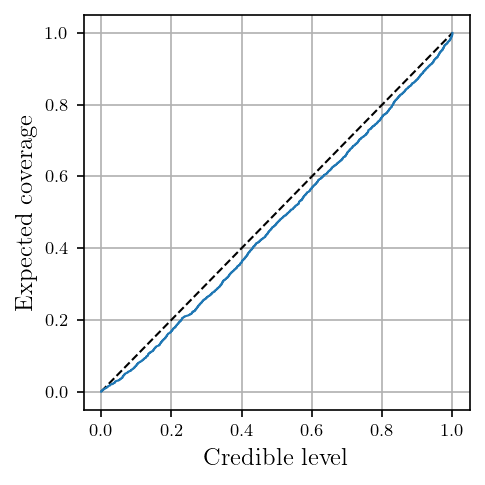

In [7]:
levels, coverages = expected_coverage_mc(estimator.flow, iterator)
fig = coverage_plot(levels, coverages)

## Corner

In [8]:
eventset = H5Dataset(datapath / 'event.h5')
theta_star, x_star = eventset[1]

In [9]:
with torch.no_grad():
    theta = estimator.flow(x_star.cuda()).sample((2**16,)).cpu()

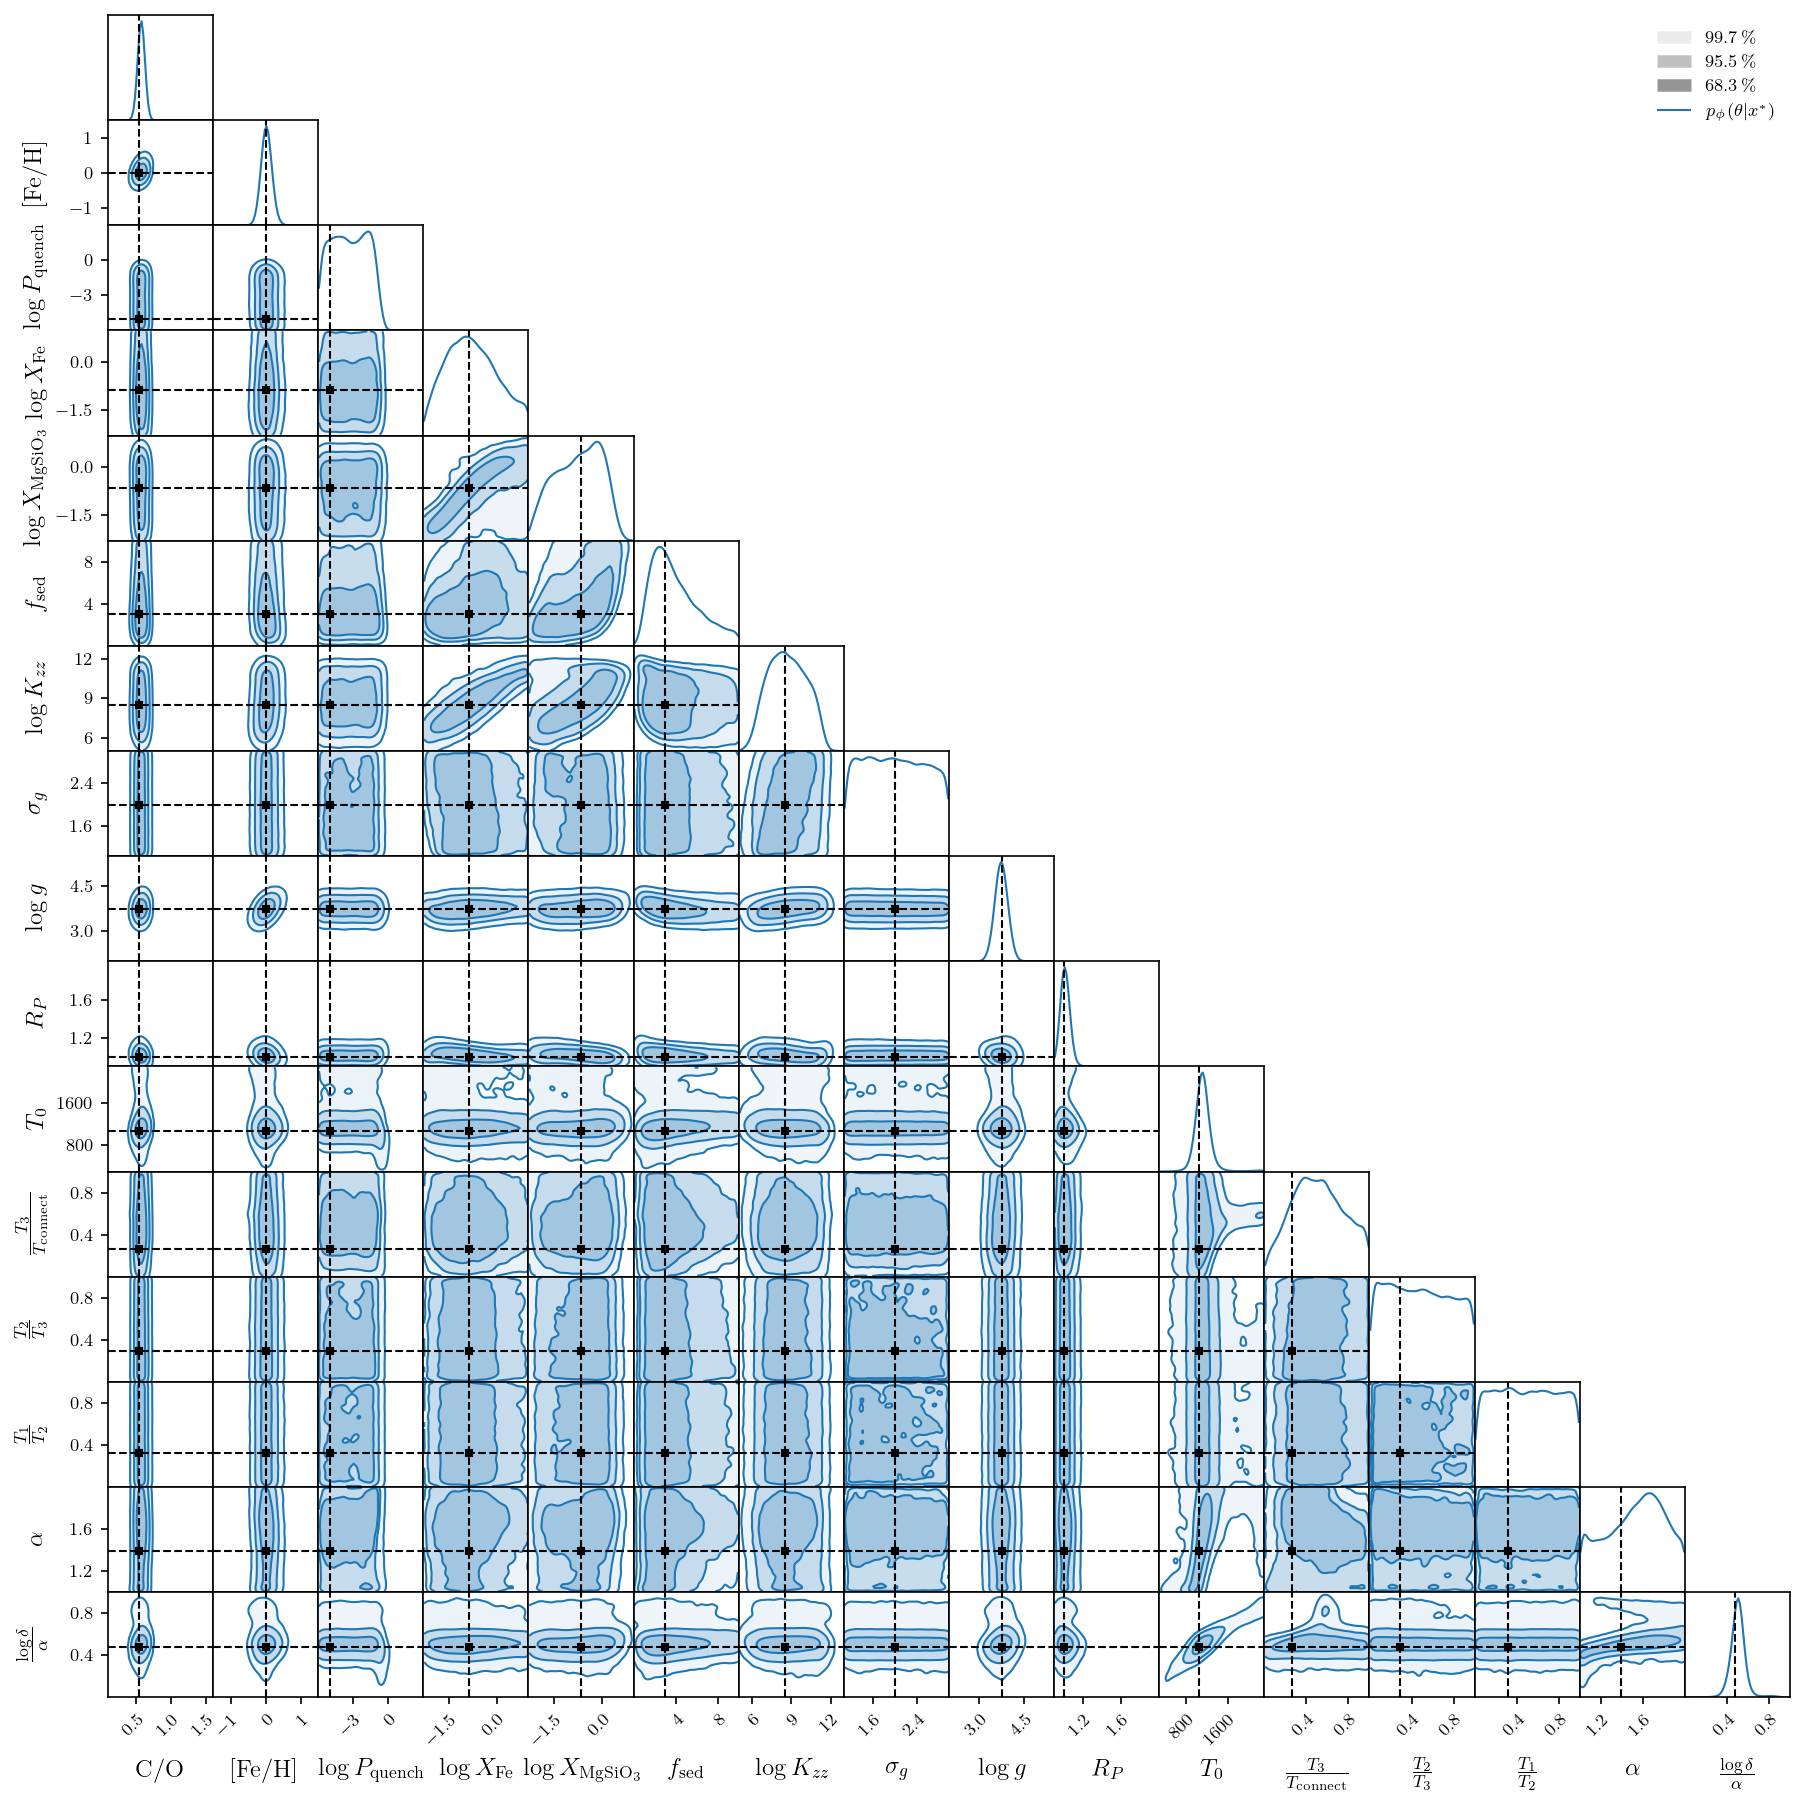

In [10]:
fig = corner(
    theta,
    smooth=2,
    domain=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_{\phi}(\theta | x^*)$',
    figsize=(12, 12),
)

mark_point(fig, theta_star)

## PT-profile

In [11]:
theta_star, x_star = theta_star.double().numpy(), x_star.double().numpy()
theta = theta[:256].double().numpy()

pressure = simulator.atmosphere.press / 1e6
temperature = pt_profile(theta, pressure)
temperature_star = pt_profile(theta_star, pressure)

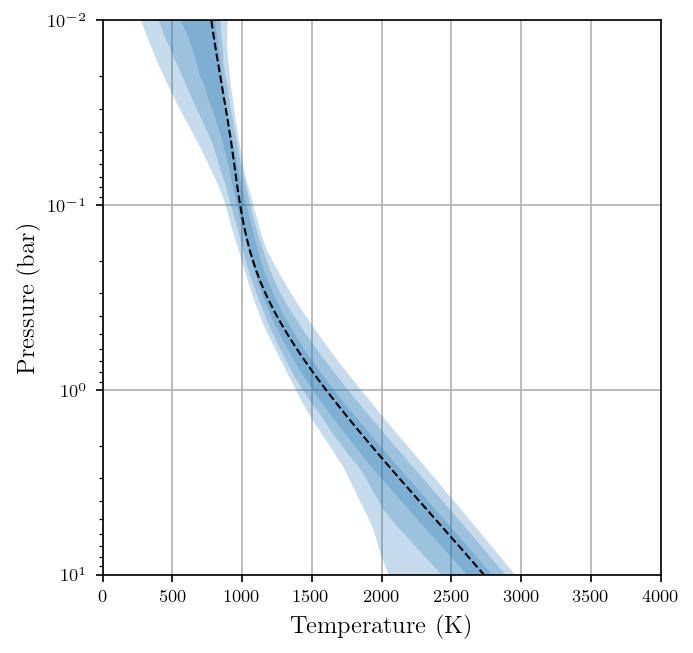

In [12]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

for q in [0.997, 0.95, 0.68]:
    left, right = np.quantile(temperature, [0.5 - q / 2, 0.5 + q / 2], axis=0)
    ax.fill_betweenx(pressure, left, right, color='C0', alpha=0.25, linewidth=0)

ax.plot(temperature_star, pressure, color='k', linestyle='--')

ax.set_xlabel(r'Temperature $(\mathrm{K})$')
ax.set_xlim(0, 4000)
ax.set_ylabel(r'Pressure $(\mathrm{bar})$')
ax.set_ylim(1e-2, 1e1)
ax.set_yscale('log')
ax.invert_yaxis()
ax.grid()

fig.savefig(runpath / 'pt_profile.pdf')

## Consistency

In [13]:
x = np.stack([simulator(t) for t in tqdm(theta)])

mask = ~np.isnan(x).any(axis=-1)
theta, x = theta[mask], x[mask]

wlength = np.linspace(0.95, 2.45, x.shape[-1])

100%|██████████| 256/256 [20:07<00:00,  4.72s/it]


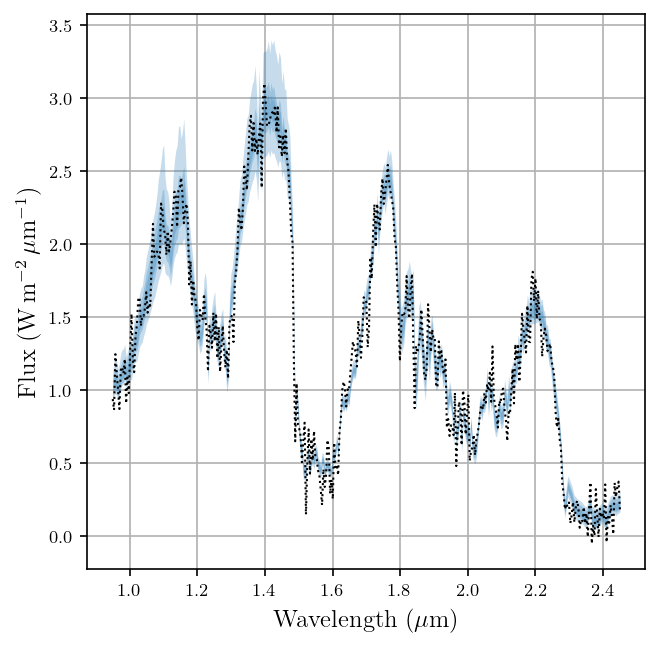

In [14]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

for q in [0.997, 0.95, 0.68]:
    lower, upper = np.quantile(x, [0.5 - q / 2, 0.5 + q / 2], axis=0)
    ax.fill_between(wlength, lower, upper, color='C0', alpha=0.25, linewidth=0)

ax.plot(wlength, x_star, color='k', linestyle=':')

ax.set_xlabel(r'Wavelength $(\mu\mathrm{m})$')
ax.set_ylabel(r'Flux $(\mathrm{W} \, \mathrm{m}^{-2} \, \mu\mathrm{m}^{-1})$')
ax.grid()

fig.savefig(runpath / 'consistency.pdf')